##### Please refer to the enclosed pdf report for a detailed walk-through of this project

In [1126]:
import pandas as pd
import pickle
import time
import nltk
import glob
import tweepy

# import TwitterCollector
from TwitterCollector import TwitterCollector
from datetime import datetime

In [1117]:
pd.set_option('max_colwidth', 400)

In [1106]:
# bearer_token = r"AAAAAAAAAAAAAAAAAAAAAMhkhgEAAAAAvNa0avRBeclZVEvCaCHQw5yAEss%3DnUlUCbJWSSwHYce0NJsX4D9TRcpjtI4d1bIRX5WZsMPnTvKkOp"

bearer_token =r"" #the bearer_token has been hidden for security purposes

# initializing a TwitterCollector instance
tc = TwitterCollector(bearer_token = bearer_token)

# Part A - Keyword Selection and Data Collection

### 1.	Picking keywords of interest - (related to the recent Football Stampede in Indonesia)

In [1054]:
#here, we are making a list of 2 queries with different set of keyword combinations, in both the queries we are excluding retweets and selecting the tweets in English language only
queries = ['indonesia soccer -is:retweet lang:en','football stampede -is:retweet lang:en']

### 2.	Collecting 10K recent tweets on the selected keywords

In [455]:
%%time

#each query in our query_to_use list is fetching 5000 tweets and appending the result to recent_tweets_list
recent_tweets_list = []
for query_to_use in queries:
    print(query_to_use)
    recent_tweets = tc.fetch_recent_tweets(query = query_to_use  # specify the search query
                                                , tweets_cnt = 5000  # specify the number of tweets you want to collect
                                                , save_result = False  # if True, the tweets will be automatically saved to a json file apart from the value returned
                                                )
    recent_tweets_list.append(recent_tweets)

indonesia soccer -is:retweet lang:en
football stampede -is:retweet lang:en
CPU times: total: 1.5 s
Wall time: 1min 7s


In [1118]:
#How many tweets did we get for query?
for i in recent_tweets_list:
    print(len(i['tweets']))

5000
5000


In [1008]:
#combining the data fetched in list in one dataframe of 10k tweets
recent_tweets_df=[]
for tweet_chunk in recent_tweets_list:
    recent_tweets_df.append(pd.DataFrame(tweet_chunk))
recent_tweets_df = pd.concat(recent_tweets_df).reset_index(drop = True)

#use this dataframe later if you wish to look at the 10000 tweets that were fetched
recent_tweets_df.drop_duplicates().to_pickle('recent_tweets_df.pkl')

# recent_tweets_df = pd.read_pickle('recent_tweets_df.pkl')

In [1152]:
#The tweet data is available from around 11:58 pm of October 1st, 2022 to 9:30 pm of October 3rd, 2022
print(f"Earliest collected Tweet time - { min(recent_tweets_df['tweets'].apply(lambda x: x['created_at'])) }")
print(f"Latest collected Tweet time - { max(recent_tweets_df['tweets'].apply(lambda x: x['created_at'])) } ")

Earliest collected Tweet time - 2022-10-01T23:58:44.000Z
Latest collected Tweet time - 2022-10-03T21:30:55.000Z 


In [521]:
#converting the df to a dictionary to perform further operations later on
recent_tweets = recent_tweets_df.to_dict()
len(recent_tweets['tweets'])

### 3.	From the collected tweets, getting the list of unique author IDs

In [1237]:
recent_tweets['tweets'][1]

{'created_at': '2022-10-03T21:30:05.000Z',
 'edit_history_tweet_ids': ['1577048366353354752'],
 'entities': {'annotations': [{'start': 23,
    'end': 31,
    'probability': 0.9324,
    'type': 'Place',
    'normalized_text': 'Indonesia'}],
  'urls': [{'start': 65,
    'end': 88,
    'url': 'https://t.co/A0CBeVTIJF',
    'expanded_url': 'http://dlvr.it/SZRy4l',
    'display_url': 'dlvr.it/SZRy4l',
    'images': [{'url': 'https://pbs.twimg.com/news_img/1577048369369092096/8Mm-f9Bo?format=jpg&name=orig',
      'width': 3000,
      'height': 1688},
     {'url': 'https://pbs.twimg.com/news_img/1577048369369092096/8Mm-f9Bo?format=jpg&name=150x150',
      'width': 150,
      'height': 150}],
    'status': 200,
    'title': 'Your Tuesday Briefing: Indonesia Investigates Its Soccer Tragedy',
    'description': 'Plus Brazil’s elections move to a runoff and Ukraine surges forward in the Donbas.',
    'unwound_url': 'https://www.nytimes.com/2022/10/03/briefing/indonesia-soccer-investigate-asia.htm

In [1122]:
#using a list concatenation to get the author ids (not unique)
author_ids = [ tweet['author_id'] for tweet in recent_tweets['tweets'].values() ]

In [1123]:
#to get unique author_ids, we are converting the above list to set and then reconverting to a list
unique_author_ids = list( set(author_ids) )

In [1125]:
print(f'There are {len(unique_author_ids)} unique author_ids')

There are 5898 unique author_ids


In [1020]:
#saving the unique author_ids to a pickle file
pd.DataFrame({'unique_author_ids':unique_author_ids}).to_pickle('unique_author_ids.pkl')

### 4.	Collecting the author information of these author IDs

In [ ]:
%%time
#due to the API's Rate Limit Policy, author info is being fetched in chunks of 3000 at a time. For each chunk of 3000 author_ids, the below script attempts to query for the info, and handles exceptions effectively by obeying the wait time.  

author_info_list = []
error_author_ids = []
errors = []

for author_id in unique_author_ids[3000:]:
    try:
        author_info = tc.fetch_author_info(author_id)
        author_info_list.append(author_info)
    except Exception as e:
        if e.args[0] == "'NoneType' object has no attribute 'data'":
            continue
        else:
            print('waiting for 15 mins...')
            time.sleep(910)
            print(f'author info fetched till now: {len(author_info_list)}')
            error_author_ids.append(author_id)
            errors.append(e)

waiting for 15 mins...
author info fetched till now: 45
waiting for 15 mins...
author info fetched till now: 344
waiting for 15 mins...
author info fetched till now: 644
waiting for 15 mins...


In [1077]:
#Below are all the files that have author information for all the required Author IDs

# pd.DataFrame(author_info_list).to_pickle('author_info_list_2988.pkl')

# pd.DataFrame(author_info_list).to_pickle('author_info_list_2988_error_7.pkl')

# pd.DataFrame(author_info_list).to_pickle('author_info_list_2885_error_10.pkl')

# pd.DataFrame(author_info_list).to_pickle('author_info_list_2885.pkl')

In [1133]:
#aggregating all the author info pickle files into one dataframe - 
author_info_df = pd.concat( [ pd.read_pickle(x) for x in glob.glob('author_info_list_*.pkl') ] )

In [1232]:
author_info_df.sample(1)

,created_at,verified,username,public_metrics,id,description,name,location,withheld,influence_score
420,2022-08-30T12:06:13.000Z,False,flashscorelive,"{'followers_count': 4, 'following_count': 32, 'tweet_count': 3507, 'listed_count': 0}",1564585209609207822,Football live scores page on https://t.co/yXutqdLLF9 offers all the latest football results Flash Score Live\n#sports #football,FLASH SCORE LIVE,NaN,NaN,3543


# --------------------------------------------------------------------------------------------------------

# Part B - Preliminary Analysis

In [1134]:
# looping over the tweets and creating a nested list of size 10000 with each sublist representing list of words in that tweet 
tweet_text_nested_list = [ tweet['text'].lower().split() for tweet in recent_tweets['tweets'].values() ]

In [573]:
#Un-nesting the nested list to get a single list of all the words mentioned in all the 10k tweets
words = [x for sublist in tweet_text_nested_list for x in sublist]

In [1172]:
len(words)

198260

### 1.	What are the ten most popular words with and without stop words?

#### Ten most popular words WITH stop words

,Word,Counts
0,in,7253
1,at,6798
2,stampede,5586
3,indonesia,5203
4,the,4872
5,football,4752
6,soccer,4660
7,a,4458
8,match,4191
9,to,2989


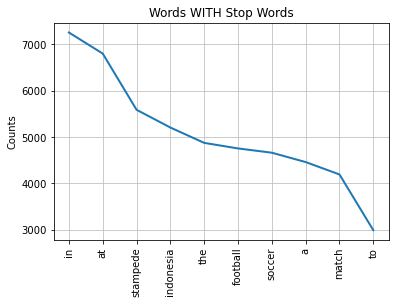

In [1136]:
freq = nltk.FreqDist(words) 
display( pd.DataFrame( freq.most_common(10) ,columns=['Word','Counts']) )
freq.plot(10,show = False);
plt.xlabel('')
plt.title('Words WITH Stop Words')
plt.show()

#### Ten most popular words WITHOUT stop words

In [1137]:
stopwords = nltk.corpus.stopwords.words('english')
#extending the default list of stopwords
stopwords.extend(['least','people'])

In [1138]:
#removing stop words, weblinks, and single-lettered words to obtain clean list of words
words_clean = [w for w in words if (w not in stopwords) and (len(w) > 1) and ('https' not in w) ]
print(len(words_clean))

125549


,Word,Counts
0,stampede,5586
1,indonesia,5203
2,football,4752
3,soccer,4660
4,match,4191
5,stadium,2329
6,police,2211
7,dead,2167
8,killed,2050
9,125,1719


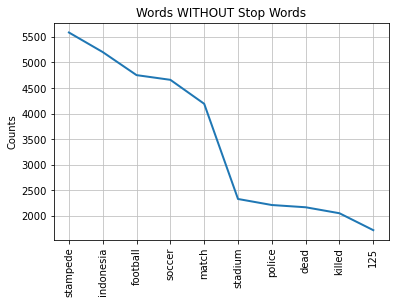

In [1139]:
freq = nltk.FreqDist(words_clean) 
display( pd.DataFrame( freq.most_common(10) ,columns=['Word','Counts']) )
freq.plot(10,show = False);
plt.xlabel('')
plt.title('Words WITHOUT Stop Words')
plt.show()

### 2.	What are the ten most popular hashtags (#hashtag)?

In [1233]:
#extracting all words which start with '#' (hashtag)
def frequent_hashtags(words_list, top_n=10):
    hashtags = [word for word in words_list if word.startswith('#')]
    freq = nltk.FreqDist(hashtags)
    return freq.most_common(top_n)

top_hashtags = frequent_hashtags(words_clean)

pd.DataFrame( top_hashtags,columns=['Hashtag','Counts'] )

,Hashtag,Counts
0,#indonesia,939
1,#football,330
2,#stampede,304
3,#indonesiafootball,253
4,#soccer,188
5,#news,164
6,#indonesianfootball,131
7,#kanjuruhanstadium,114
8,#persebaya,113
9,#breakingnews,109


### 3.	What are the ten most frequently mentioned usernames (@username)?

In [1234]:
#extracting all words which start with '@' (mentions)
def frequent_usernames(words_list, top_n=10):
    usernames = [word for word in words_list if word.startswith('@')]
    freq = nltk.FreqDist(usernames)
    return freq.most_common(top_n)

top_usernames = frequent_usernames(words_clean)

pd.DataFrame( top_usernames,columns=['Username','Mentions'] )

,Username,Mentions
0,@ap),46
1,@fifacom,41
2,@ajenglish,39
3,@youtube,36
4,@nytimes,22
5,@reuters,19
6,@yahoo,18
7,@bukkry_,16
8,@abcaustralia,14
9,@nbcnews,13


### 4.	Which are the three most common sources of the tweets?

In [597]:
all_tweet_sources = [ tweet['source'] for tweet in recent_tweets['tweets'].values() ]

In [821]:
freq = nltk.FreqDist(all_tweet_sources)
pd.DataFrame(freq.most_common(3), columns = ['Source','Tweets'])

,Source,Tweets
0,Twitter Web App,1973
1,WordPress.com,1925
2,Twitter for Android,1382


### 5.	Create a line chart to show the time trend of tweet counts (number of tweets in a day (or an hour or a minute) depending on the collected data).

In [1156]:
datetime.strptime(recent_tweets['tweets'][0]['created_at'], '%Y-%m-%dT%H:%M:%S.%fZ')

datetime.datetime(2022, 10, 3, 21, 30, 55)

In [1157]:
#From tweet data, we are extracing tweet time, and then storing the datetime converted values in a list 
all_tweet_times = [ datetime.strptime(tweet['created_at'], '%Y-%m-%dT%H:%M:%S.%fZ') for tweet in recent_tweets['tweets'].values() ]
all_tweet_times.sort() #sorting the list of datetimes

#earliest and latest tweet time
str(min(all_tweet_times)), str(max(all_tweet_times))

('2022-10-01 23:58:44', '2022-10-03 21:30:55')

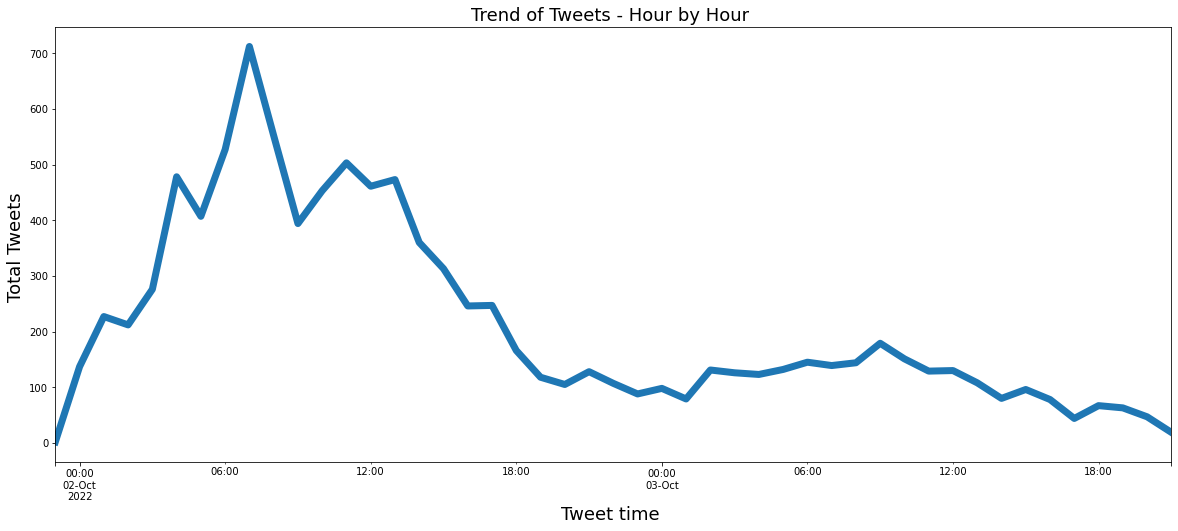

In [1158]:
df_tweet_time = pd.DataFrame({'tweet_time': all_tweet_times})
df_tweet_time.groupby([ df_tweet_time['tweet_time'].dt.to_period('H') ]).size().plot(figsize = (20,8), linewidth=7.0)
plt.xlabel('Tweet time ',fontsize=18)
plt.ylabel('Total Tweets ',fontsize=18)
plt.title('Trend of Tweets - Hour by Hour ',fontsize=18)
plt.show()

### 6.	Which are the three most influential tweets? A tweet’s influence score is the sum of “quote_count”, “reply_count”, “retweet_count”, “like_count”. These counts can be found in the “public_metrics” in the tweet data.

In [1159]:
# public_metrics = [ { tweet['id']: sum( tweet['public_metrics'].values() ) } for tweet in recent_tweets['tweets'].values() ]

In [863]:
#creating a dataframe of relevant columns to analyze tweets based on public metrics 
recent_tweets_public_df = pd.DataFrame.from_dict(recent_tweets['tweets']).T[['id','text','public_metrics']]

In [864]:
recent_tweets_public_df['influence_score'] = recent_tweets_public_df['public_metrics'].apply(lambda x: sum(x.values()) )

In [869]:
#finding 3 most influential tweets on this topic by using Pandas df's nlargest method
recent_tweets_public_df.nlargest(3,'influence_score')

,id,text,public_metrics,influence_score
9927,1576372644345167875,Indonesia: More than 120 dead in football stampede https://t.co/rnW81bmVLz,"{'retweet_count': 7441, 'reply_count': 691, 'like_count': 36565, 'quote_count': 1077}",45774
6099,1576612882862718981,Arema fans gather after at least 125 people were killed following an Indonesian league football match against Persebaya.\n\nMany were trampled to death or suffocated after police fired tear gas during the chaos and a stampede occurred. Over 300 people were taken to hospitals. https://t.co/iTzdZbczh7,"{'retweet_count': 5645, 'reply_count': 147, 'like_count': 23716, 'quote_count': 136}",29644
8486,1576463565401325569,"Indonesia police fire tear gas after fans invade football pitch in East Java, triggering a stampede that killed at least 129 people https://t.co/wGWbgTsLY7 https://t.co/kopf7Dxlk2","{'retweet_count': 3262, 'reply_count': 221, 'like_count': 9030, 'quote_count': 193}",12706


### 7.	Who are the three most vocal authors on the keyword? In other words, who are the most frequently tweeting authors in the tweet data? 

In [1162]:
#extracing author_ids from the tweet data
all_tweet_author_ids = [ tweet['author_id'] for tweet in recent_tweets['tweets'].values() ]

In [1182]:
#3 most vocal author_ids
most_vocal_3 = pd.Series(all_tweet_author_ids).value_counts().nlargest(3).reset_index().rename(columns = {'index':'author_id',0:'tweets'})
most_vocal_3

,author_id,tweets
0,1351660896527872000,56
1,1476165846057644034,43
2,283604227,40


In [1190]:
author_info_df[author_info_df['id']=='1351660896527872000']

,created_at,verified,username,public_metrics,id,description,name,location,withheld
852,2021-01-19T22:40:58.000Z,False,AureliaMawar,"{'followers_count': 186, 'following_count': 77, 'tweet_count': 75140, 'listed_count': 0}",1351660896527872000,"For more updates on stories related to Indonesia in English, you can check Newsnow.",Mawar Aurelia,"Jakarta Capital Region, Indone",NaN


In [1189]:
#merging the above author_id frequency dataframe (most_vocal_3) with the author_info dataframe to understand type of authors
most_vocal_3.merge(author_info_df.set_index('id'),left_on='author_id',right_index=True)

,author_id,tweets,created_at,verified,username,public_metrics,description,name,location,withheld
0,1351660896527872000,56,2021-01-19T22:40:58.000Z,False,AureliaMawar,"{'followers_count': 186, 'following_count': 77, 'tweet_count': 75140, 'listed_count': 0}","For more updates on stories related to Indonesia in English, you can check Newsnow.",Mawar Aurelia,"Jakarta Capital Region, Indone",NaN
1,1476165846057644034,43,2021-12-29T12:19:23.000Z,False,usasharenews,"{'followers_count': 593, 'following_count': 2078, 'tweet_count': 501987, 'listed_count': 1}",usa share news,usa share news,Etats-Unis,NaN
2,283604227,40,2011-04-17T16:39:35.000Z,False,AndyVermaut,"{'followers_count': 31243, 'following_count': 34305, 'tweet_count': 1946445, 'listed_count': 59}","Linked to WCPDCD, \nEADM, \nPOSTVERSA, \nAIDL, \nEUtoday, \nActNow for C, \nPeople Forests, \nFundamental rights.\nWhatsapp +32499357495 \ndenktankcarmenta@gmail.com",Andy Vermaut,"Diksmuide, België",NaN


### 8.	Who are the three most influential authors? A user’s influence score is the sum of “followers_count”, “following_count”, “listed_count”. “tweet_count” in the author data.

In [1193]:
#calculating the influence_score by summing the values of public_metrics dictionary and storing it as a new column in author_info_df
author_info_df['influence_score'] = author_info_df.apply(lambda row: sum( row['public_metrics'].values() ), axis = 1)

In [1197]:
#3 most influential authors
author_info_df.nlargest(3, 'influence_score')

,created_at,verified,username,public_metrics,id,description,name,location,withheld,influence_score
2712,2007-03-02T20:41:42.000Z,True,nytimes,"{'followers_count': 54469861, 'following_count': 872, 'tweet_count': 486578, 'listed_count': 217593}",807095,News tips? Share them here: https://t.co/ghL9OoYKMM,The New York Times,New York City,NaN,55174904
1561,2007-04-22T14:42:37.000Z,True,BBCBreaking,"{'followers_count': 51277571, 'following_count': 3, 'tweet_count': 38369, 'listed_count': 148871}",5402612,"Breaking news alerts and updates from the BBC. For news, features, analysis follow @BBCWorld (international) or @BBCNews (UK). Latest sport news @BBCSport.",BBC Breaking News,"London, UK",NaN,51464814
2200,2007-02-01T07:44:29.000Z,True,BBCWorld,"{'followers_count': 38500489, 'following_count': 18, 'tweet_count': 352327, 'listed_count': 133406}",742143,"News, features and analysis from the World's newsroom. Breaking news, follow @BBCBreaking. UK news, @BBCNews. Latest sports news @BBCSport",BBC News (World),"London, UK",NaN,38986240


# --------------------------------------------------------------------------------------------------------

# Part C - Word Cloud

In [873]:
# import necessary modules
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk

%matplotlib inline

In [1198]:
#creating one string by combining all the words of the words_clean list
text = ' '.join([w for w in words_clean])

#### Wordcloud 1 - with Collocations ON and 4 Stopwords

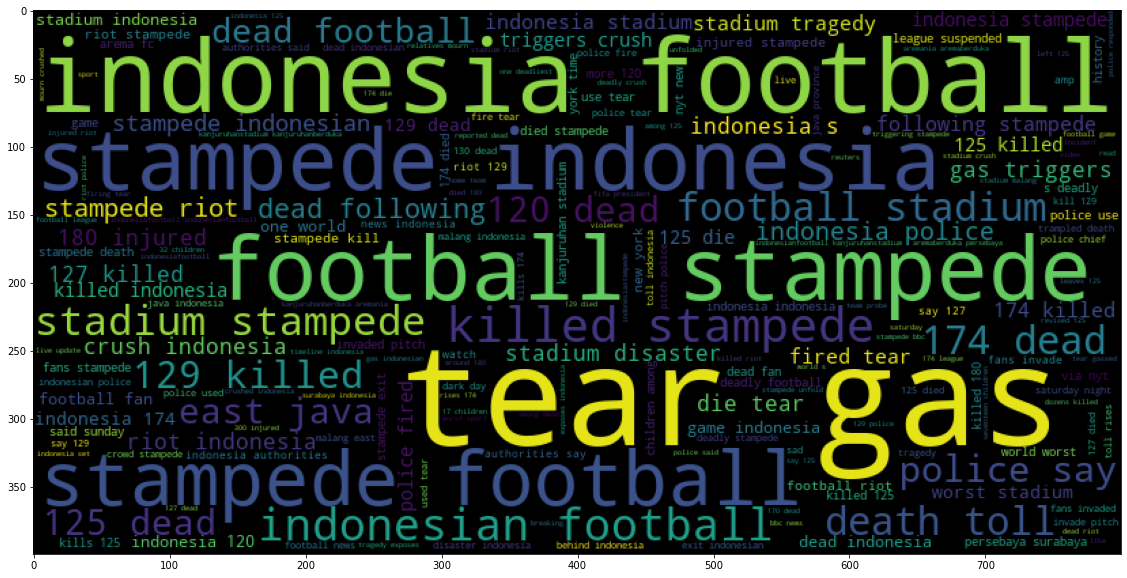

In [1200]:
 # lower max_font_size
wordcloud = WordCloud(width=800, height=400, stopwords=['soccer','least','people','match'],background_color='black', include_numbers=True, collocations=True).generate(text) # note that text is a string, not a list

# Display the generated image:
plt.figure(figsize=(20,10)) # set up figure size
plt.imshow(wordcloud) # word cloud image show
plt.axis("on") # turn on axis
plt.savefig('my_word_cloud_1.png') # save as PNG file
plt.savefig('my_word_cloud_1.pdf') # save as PDF file
plt.show()  # show in Jupyter notebook

#### Wordcloud 2 - with Collocations ON and 7 Stopwords

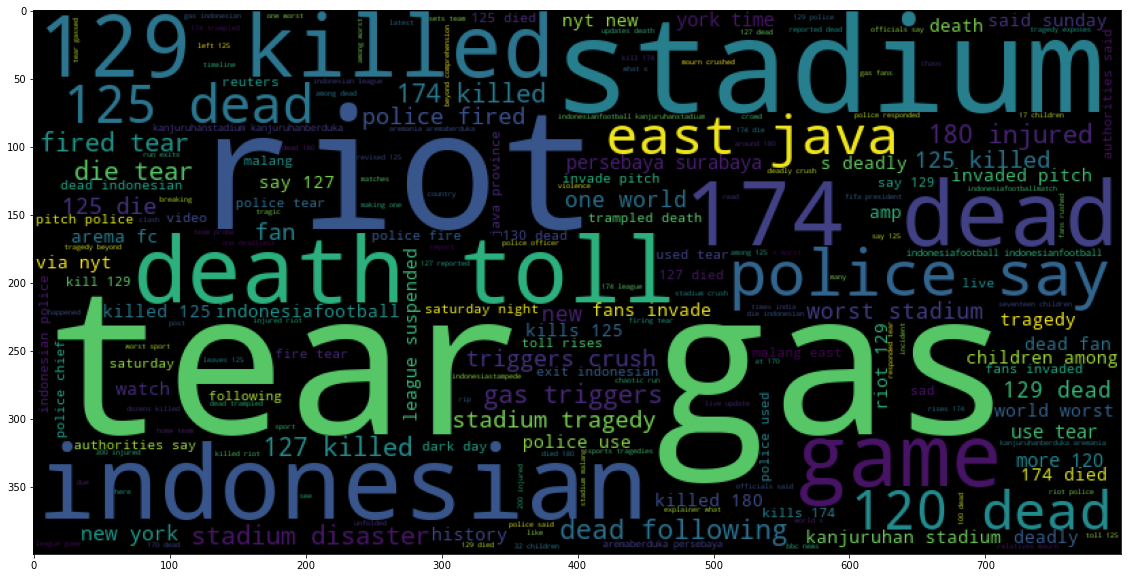

In [1202]:
 # lower max_font_size
wordcloud = WordCloud(width=800, height=400, stopwords=['soccer','stampede','indonesia','football','least','people','match'],background_color='black', include_numbers=True, collocations=True).generate(text) # note that text is a string, not a list

# Display the generated image:
plt.figure(figsize=(20,10)) # set up figure size
plt.imshow(wordcloud) # word cloud image show
plt.axis("on") # turn on axis
plt.savefig('my_word_cloud_1.png') # save as PNG file
plt.savefig('my_word_cloud_1.pdf') # save as PDF file
plt.show()  # show in Jupyter notebook

#### Wordcloud 3 - with Collocations OFF and 8 Stopwords

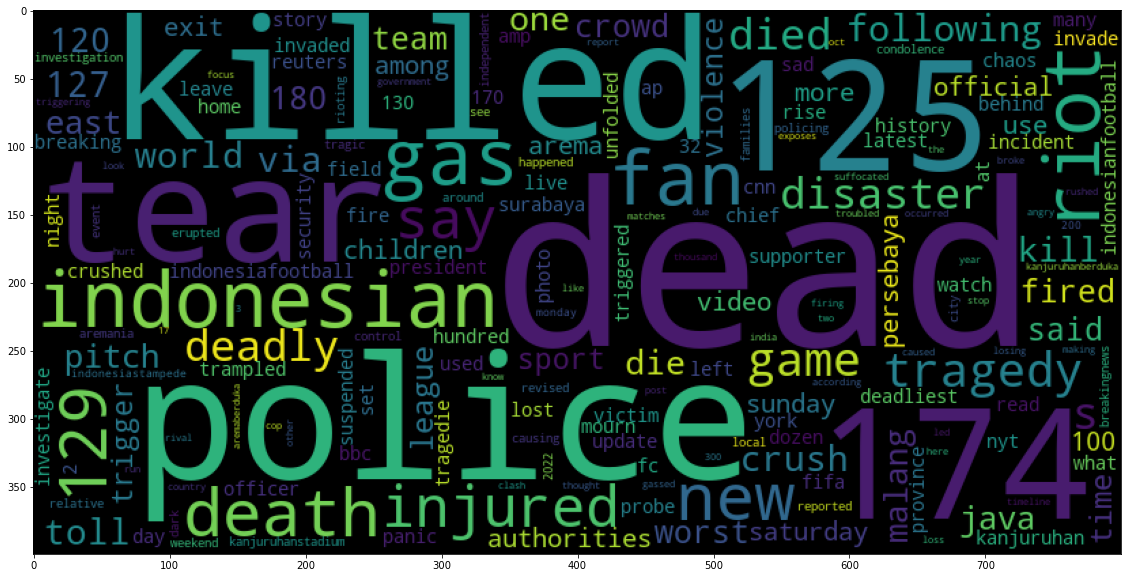

In [1204]:
 # lower max_font_size
wordcloud = WordCloud(width=800, height=400, stopwords=['soccer','stampede', 'stadium','indonesia','football','least','people','match'],background_color='black', include_numbers=True, collocations=False).generate(text) # note that text is a string, not a list

# Display the generated image:
plt.figure(figsize=(20,10)) # set up figure size
plt.imshow(wordcloud) # word cloud image show
plt.axis("on") # turn on axis
plt.savefig('my_word_cloud_1.png') # save as PNG file
plt.savefig('my_word_cloud_1.pdf') # save as PDF file
plt.show()  # show in Jupyter notebook

# Part D - Sentiment Analysis

In [943]:
from textblob import TextBlob

In [968]:
#creating a required dataframe by using the recent_tweets dictionary, Transposing it, and then extracting required columns
sentiment_df = pd.DataFrame.from_dict(recent_tweets['tweets']).T[['id','text']]

In [969]:
sentiment_df['sentiment_subjectivity'] = sentiment_df['text'].astype(str).apply(lambda x: TextBlob(x).sentiment.subjectivity)
sentiment_df['sentiment_polarity'] = sentiment_df['text'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

In [1207]:
#a sample row of the dataframe with subjectivity and polarity scores
sentiment_df.sample(1)

,id,text,sentiment_subjectivity,sentiment_polarity
8191,1576474024774885386,Indoensia Football Stampede: At least 129 dead after riot at Indonesia football match | World News – Times of India https://t.co/XP54fkda4G,0.4,-0.25


### 1.	What are the average polarity and subjectivity scores?

In [983]:
sentiment_df[['sentiment_subjectivity','sentiment_polarity']].mean().to_frame().rename(columns = {0:'Average Score'})

,Average Score
sentiment_subjectivity,0.306436
sentiment_polarity,-0.119004


### 2.	Visualizing the polarity and subjectivity score distributions using histograms, where X-axis is the score and Y-axis is the tweet count in the score bin.

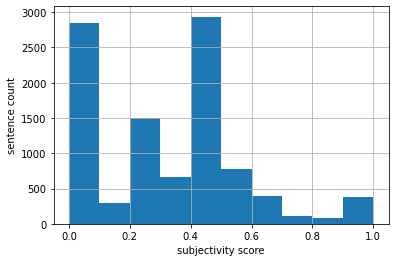

In [1212]:
import matplotlib.pyplot as plt

plt.hist(sentiment_df['sentiment_subjectivity'].tolist(), bins=10) #, normed=1, alpha=0.75)

plt.xlabel('subjectivity score')
plt.ylabel('sentence count')
plt.grid(True)
plt.savefig('subjectivity.pdf')
plt.show()

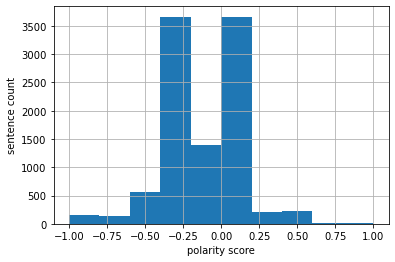

In [984]:
plt.hist(sentiment_df['sentiment_polarity'].tolist(), bins=10) #, normed=1, alpha=0.75)

plt.xlabel('polarity score')
plt.ylabel('sentence count')
plt.grid(True)
plt.savefig('polarity.pdf')
plt.show()

### 3.	Based on the polarity scores, what are the most positive and negative tweets on the keyword? Why is the author happy/angry on the topic?

In [986]:
#The 3 tweets which were given the most positive polarity by TextBlob
sentiment_df.nlargest(3,'sentiment_polarity')

,id,text,sentiment_subjectivity,sentiment_polarity
3772,1576511063092514816,"Our thoughts &amp; prayers are with the victims in Malang ~Indonesia~\n🕯❤️🙏🏽\n\nFootball should be a source of joy. No violence, by fans or police, should ever be accepted!\n\nhttps://t.co/3eIF6Izd6E\n\n#football #soccer #Indonesiafootball #Malang #prayers #Java",0.2,1.000000
2882,1576567975468945408,@lisaabramowicz1 2022 G20 meeting is in Bali Indonesia…if violence in soccer game..hope our leaders will be secure..!!!! https://t.co/2s3EzTQC5l,0.6,0.976562
5611,1576784544681844737,How a football match upset win led to violence and stampede in Indonesia https://t.co/y7L9hRDYyJ,0.4,0.800000


In [990]:
#since there are many tweets with negative sentiments, we are picking 3 sample tweets 1576384731595550720, 1576562614842556417, 1576584747694043136
sentiment_df.loc[sentiment_df['sentiment_polarity']==-1].sample(3)

,id,text,sentiment_subjectivity,sentiment_polarity
9721,1576384731595550720,A post-match clash between supporters of two Indonesian soccer teams in East Java has led to horrific deaths as hundreds are rushed to nearby hospitals.\n\nhttps://t.co/LB8dNihQPv,1.0,-1.0
6511,1576562614842556417,"Indonesia Football Match Stampede Kills 174, Among Worst Sports Tragedies https://t.co/fFNKLF1bNF",1.0,-1.0
2611,1576584747694043136,"Preventable tragedy+loss of life on the pitch in #Indonesia’s Kanjuruhan stadium where reported 131 people died after police tear-gassed fans, triggering a stampede.\n\n@HRW calls for investigation, prosecution in one of worst stadium disasters in history”:\nhttps://t.co/CmnO08vzLx https://t.co/mbWbCG0rbl",1.0,-1.0


#### Are more Positive Sentiments or Negative Sentiments expressed in the tweets?

In [1228]:
(sentiment_df['sentiment_polarity']<0).sum()

5901

In [1229]:
(sentiment_df['sentiment_polarity']>0).sum()

1821

### ==============================================================================